# AI-Powered Disaster Response & Alert System

## Importing the required libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    classification_report,
    confusion_matrix,
    roc_curve
)
import joblib
import warnings
warnings.filterwarnings('ignore')

## Set random seed for reproducibility

In [15]:
np.random.seed(42)

## DATA GENERATION & SIMULATION

In [17]:
def generate_disaster_data(n_samples=5000):
    print("Generating disaster dataset...")
    
    data = {
        # Weather-related features
        'rainfall_mm': np.random.gamma(2, 50, n_samples),  # Gamma distribution for rainfall
        'temperature_c': np.random.normal(25, 8, n_samples),  # Temperature in Celsius
        'humidity_percent': np.random.uniform(30, 100, n_samples),  # Humidity percentage
        'wind_speed_kmh': np.random.exponential(15, n_samples),  # Wind speed
        
        # Geographical features
        'elevation_m': np.random.uniform(0, 3000, n_samples),  # Elevation in meters
        'distance_to_river_km': np.random.exponential(10, n_samples),  # Distance to nearest river
        'soil_moisture_percent': np.random.uniform(10, 90, n_samples),  # Soil moisture
        'slope_degree': np.random.uniform(0, 45, n_samples),  # Terrain slope
        
        # Socio-economic features
        'population_density': np.random.lognormal(6, 2, n_samples),  # Population per sq km
        'infrastructure_quality': np.random.choice([1, 2, 3, 4, 5], n_samples),  # 1=Poor, 5=Excellent
        
        # Historical disaster features
        'days_since_last_disaster': np.random.exponential(180, n_samples),  # Days since last event
        'historical_disaster_count': np.random.poisson(3, n_samples),  # Past disaster count
    }
    
    df = pd.DataFrame(data)
    
    # Create target variable based on logical rules
    df['risk_score'] = (
        (df['rainfall_mm'] > 100) * 3 +
        (df['distance_to_river_km'] < 2) * 2 +
        (df['soil_moisture_percent'] > 70) * 2 +
        (df['elevation_m'] < 100) * 1.5 +
        (df['slope_degree'] > 30) * 1.5 +
        (df['population_density'] > 500) * 1 +
        (df['infrastructure_quality'] <= 2) * 1.5 +
        (df['days_since_last_disaster'] < 30) * 2 +
        np.random.normal(0, 1, n_samples)  # Add some noise
    )
    
    # Categorize risk levels
    df['risk_level'] = pd.cut(
        df['risk_score'], 
        bins=[-np.inf, 4, 8, np.inf],
        labels=['Low', 'Medium', 'High']
    )
    
    # Drop the intermediate risk_score column
    df = df.drop('risk_score', axis=1)
    
    print(f"Generated {n_samples} samples with {df.shape[1]} features")
    print(f"\nRisk Level Distribution:\n{df['risk_level'].value_counts()}")
    
    return df


## DATA PREPROCESSING

In [19]:
def preprocess_data(df):
    print("\nPreprocessing data...")
    
    # Handle missing values (if any)
    df = df.fillna(df.median(numeric_only=True))
    
    # Feature Engineering
    print("Engineering new features...")
    
    # Create interaction features
    df['rainfall_soil_interaction'] = df['rainfall_mm'] * df['soil_moisture_percent']
    df['flood_risk_index'] = (df['rainfall_mm'] * 0.4 + 
                               (1 / (df['distance_to_river_km'] + 0.1)) * 100 * 0.3 +
                               df['soil_moisture_percent'] * 0.3)
    
    # Create categorical bins for continuous variables
    df['rainfall_category'] = pd.cut(df['rainfall_mm'], 
                                      bins=[0, 50, 100, 150, np.inf],
                                      labels=[0, 1, 2, 3])
    
    df['elevation_category'] = pd.cut(df['elevation_m'],
                                       bins=[0, 500, 1000, 1500, np.inf],
                                       labels=[0, 1, 2, 3])
    
    # Risk density score
    df['risk_density'] = (df['population_density'] / 
                          (df['infrastructure_quality'] + 1))
    
    # Separate features and target
    X = df.drop('risk_level', axis=1)
    y = df['risk_level']
    
    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Store feature names
    feature_names = X.columns.tolist()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Preprocessing complete!")
    print(f"Training samples: {X_train_scaled.shape[0]}")
    print(f"Testing samples: {X_test_scaled.shape[0]}")
    print(f"Features: {X_train_scaled.shape[1]}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoder, feature_names


## MODEL TRAINING

In [21]:
def train_model(X_train, y_train):
    print("\nTraining Random Forest model...")
    
    # Initialize model with optimized hyperparameters
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Handle class imbalance
    )
    
    # Train model
    model.fit(X_train, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    print(f"Model trained successfully!")
    print(f"Cross-validation F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    return model


## MODEL EVALUATION

In [23]:
def evaluate_model(model, X_test, y_test, label_encoder):
    print("\nEvaluating model performance...")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # For multi-class ROC-AUC, use one-vs-rest approach
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    
    print(f"\n{'='*50}")
    print(f"MODEL PERFORMANCE METRICS")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"{'='*50}\n")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, 
                                target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }


## VISUALIZATION

In [25]:
def create_visualizations(df, model, metrics, label_encoder, feature_names):
    print("\nCreating visualizations...")
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Confusion Matrix
    ax1 = plt.subplot(2, 3, 1)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 2. Feature Importance
    ax2 = plt.subplot(2, 3, 2)
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    sns.barplot(data=feature_imp, y='feature', x='importance', palette='viridis')
    plt.title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
    plt.xlabel('Importance Score')
    
    # 3. Risk Level Distribution
    ax3 = plt.subplot(2, 3, 3)
    risk_counts = df['risk_level'].value_counts()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title('Risk Level Distribution', fontsize=14, fontweight='bold')
    
    # 4. Correlation Heatmap (top BASE features only)
    ax4 = plt.subplot(2, 3, 4)
    # Get only the base features that exist in original df
    base_features = [
        'rainfall_mm', 'temperature_c', 'humidity_percent', 'wind_speed_kmh',
        'elevation_m', 'distance_to_river_km', 'soil_moisture_percent', 
        'slope_degree', 'population_density', 'infrastructure_quality',
        'days_since_last_disaster', 'historical_disaster_count'
    ]
    # Filter to only top features that exist in df
    available_features = [f for f in base_features if f in df.columns][:8]
    correlation_df = df[available_features]
    
    sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', 
                center=0, fmt='.2f', square=True)
    plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    
    # 5. Rainfall vs Risk Level
    ax5 = plt.subplot(2, 3, 5)
    sns.boxplot(data=df, x='risk_level', y='rainfall_mm', 
                palette=colors, order=['Low', 'Medium', 'High'])
    plt.title('Rainfall Distribution by Risk Level', fontsize=14, fontweight='bold')
    plt.ylabel('Rainfall (mm)')
    plt.xlabel('Risk Level')
    
    # 6. Model Performance Metrics
    ax6 = plt.subplot(2, 3, 6)
    metric_names = ['Accuracy', 'F1-Score', 'ROC-AUC']
    metric_values = [metrics['accuracy'], metrics['f1_score'], metrics['roc_auc']]
    bars = plt.bar(metric_names, metric_values, color=['#3498db', '#9b59b6', '#1abc9c'])
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
    plt.ylabel('Score')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('disaster_risk_analysis.png', dpi=300, bbox_inches='tight')
    print("Visualizations saved as 'disaster_risk_analysis.png'")
    plt.show()



## MODEL SAVING

In [27]:
def save_model(model, scaler, label_encoder, feature_names):
    print("\nSaving model and preprocessing objects...")
    
    model_artifacts = {
        'model': model,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'feature_names': feature_names
    }
    
    joblib.dump(model_artifacts, 'disaster_model.pkl')
    print("Model saved as 'disaster_model.pkl'")


## MAIN EXECUTION

 AI-POWERED DISASTER RESPONSE & ALERT SYSTEM
 Machine Learning Model Training Pipeline
Generating disaster dataset...
Generated 5000 samples with 13 features

Risk Level Distribution:
risk_level
Low       2570
Medium    2108
High       322
Name: count, dtype: int64

Sample data saved as 'sample_disaster_data.csv'

Preprocessing data...
Engineering new features...
Preprocessing complete!
Training samples: 4000
Testing samples: 1000
Features: 17

Training Random Forest model...
Model trained successfully!
Cross-validation F1 Score: 0.8146 (+/- 0.0154)

Evaluating model performance...

MODEL PERFORMANCE METRICS
Accuracy:  0.8220
F1-Score:  0.8221
ROC-AUC:   0.9189

Classification Report:
              precision    recall  f1-score   support

        High       0.67      0.58      0.62        64
         Low       0.89      0.85      0.87       514
      Medium       0.77      0.83      0.80       422

    accuracy                           0.82      1000
   macro avg       0.78      0.75 

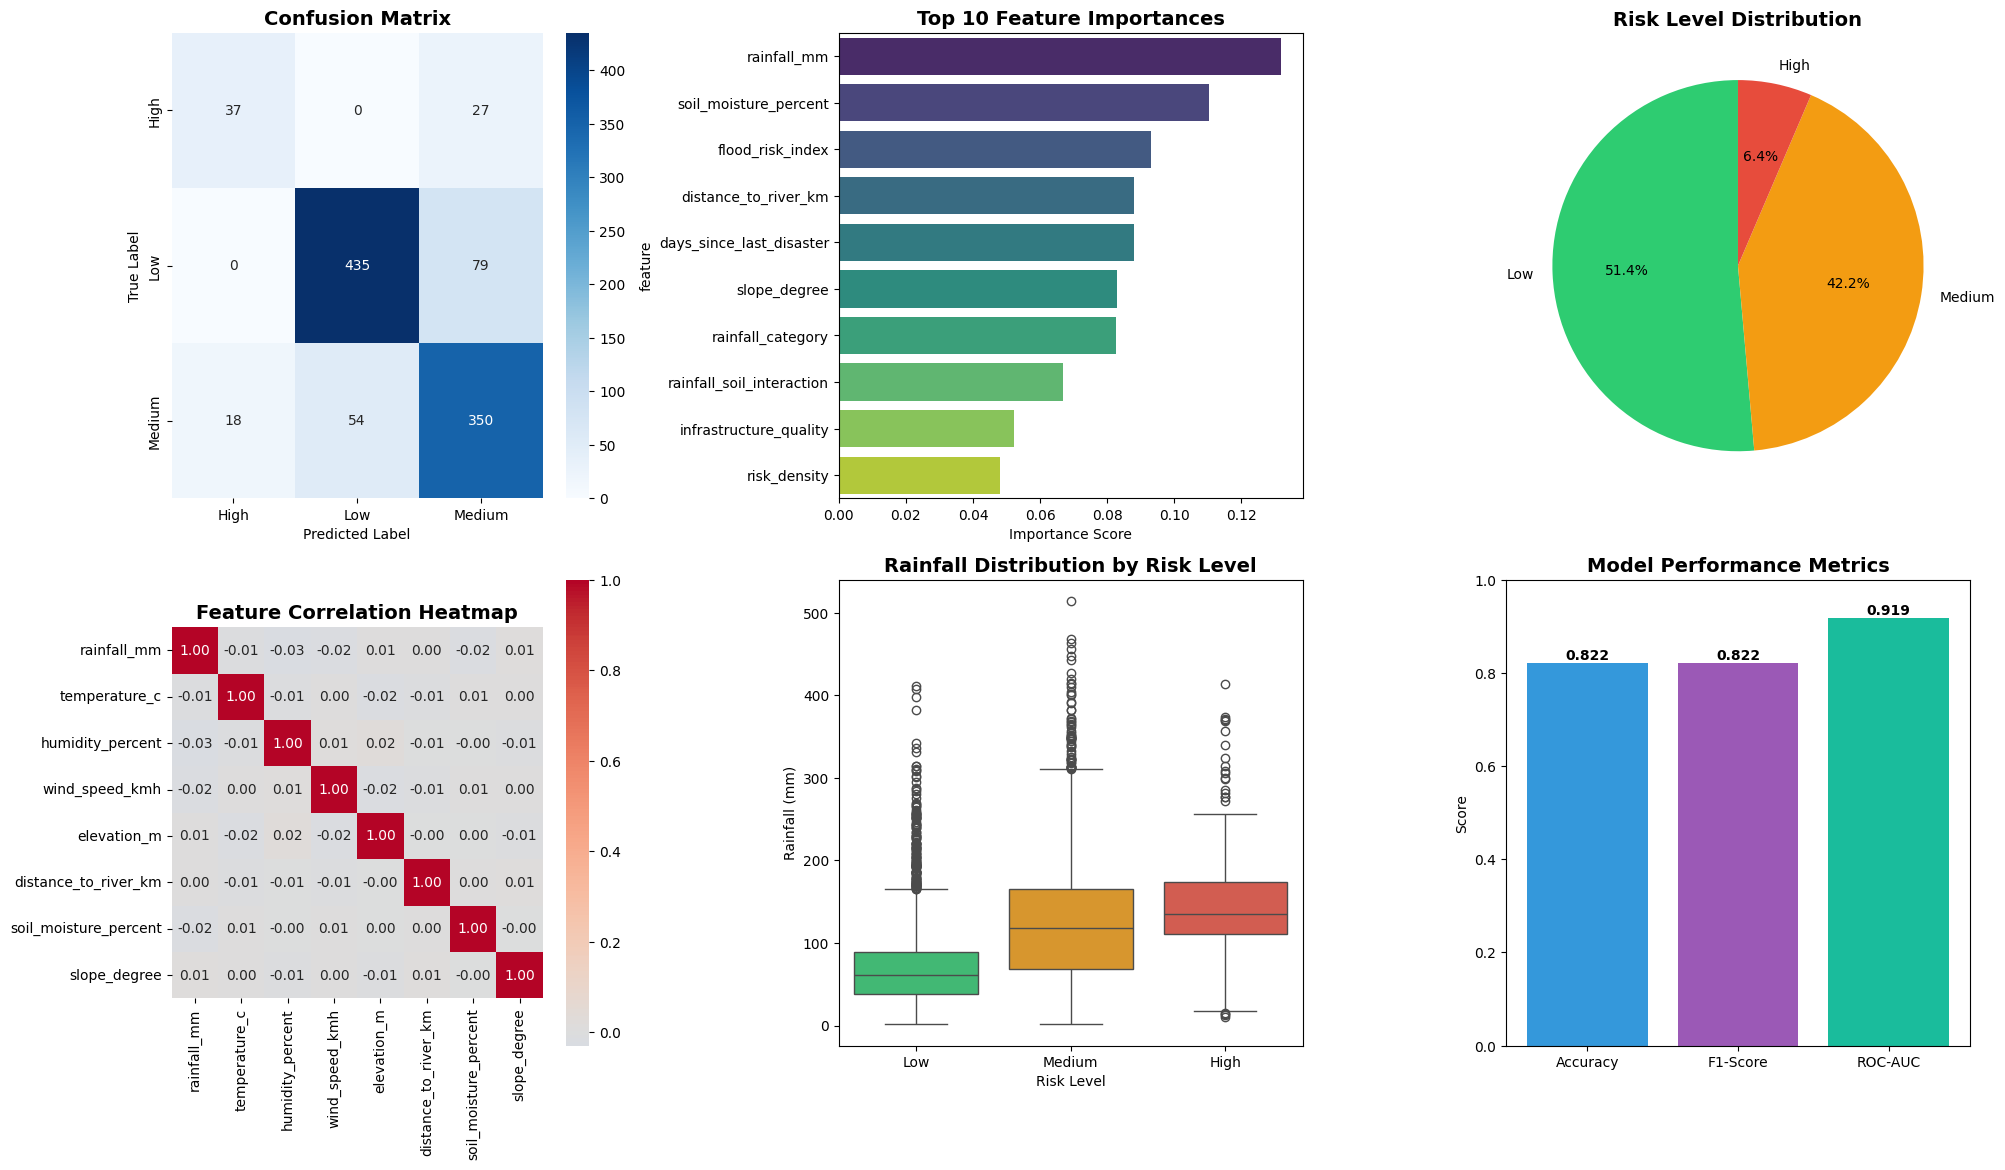


Saving model and preprocessing objects...
Model saved as 'disaster_model.pkl'


In [31]:
if __name__ == "__main__":
    print("="*70)
    print(" AI-POWERED DISASTER RESPONSE & ALERT SYSTEM")
    print(" Machine Learning Model Training Pipeline")
    print("="*70)
    
    # Step 1: Generate Data
    df = generate_disaster_data(n_samples=5000)
    
    # Save sample data for reference
    df.head(100).to_csv('sample_disaster_data.csv', index=False)
    print("\nSample data saved as 'sample_disaster_data.csv'")
    
    # Step 2: Preprocess Data
    X_train, X_test, y_train, y_test, scaler, label_encoder, feature_names = preprocess_data(df)
    
    # Step 3: Train Model
    model = train_model(X_train, y_train)
    
    # Step 4: Evaluate Model
    metrics = evaluate_model(model, X_test, y_test, label_encoder)
    
    # Step 5: Create Visualizations
    create_visualizations(df, model, metrics, label_encoder, feature_names)
    
    # Step 6: Save Model
    save_model(model, scaler, label_encoder, feature_names)